# Various Comparison For Teacher and Student Models

# Generic code

In [1]:
import torch
import numpy as np
import gc
import time
import math
import logging
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextGenerationPipeline

# Setup logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

# Set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Helper function to load model and tokenizer
def load_model_and_tokenizer(model_name, device):
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)
    tokenizer.padding_side = "left"
    # Set pad_token if it's not already set
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))  # Update the model's token embeddings
    model.to(device)
    return model, tokenizer

# Function to create a text generation pipeline with the correct pad_token
def create_text_generator(model, tokenizer, device):
    text_generator = TextGenerationPipeline(model=model, tokenizer=tokenizer, device=device)
    # Ensure the pipeline uses the correct pad_token_id
    text_generator.tokenizer.pad_token_id = tokenizer.pad_token_id
    return text_generator

# Function to generate sequences and measure the time taken
def generate_sequences(text_generator, input_text="A", num_sequences=10, max_length=100):
    start_time = time.time()
    input_texts = [input_text for _ in range(num_sequences)]  # Create a list of the same input text
    sequences = text_generator(
        input_texts,
        max_length=max_length,
        do_sample=True,
        top_k=950,
        repetition_penalty=1.2,
        num_return_sequences=1,
        pad_token_id=text_generator.tokenizer.pad_token_id,
        eos_token_id=0,
        truncation=True,
        batch_size=num_sequences  # Process all sequences at once
    )
    elapsed_time = time.time() - start_time
    return elapsed_time

# Function to calculate perplexity
def calculate_perplexity(sequence, model, tokenizer, device):
    input_ids = torch.tensor(tokenizer.encode(sequence)).unsqueeze(0)
    input_ids = input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss = outputs.loss
    return math.exp(loss)

def generate_and_calculate_ppl(text_generator, device, num_sequences=10):
    input_prompts = ["<|endoftext|>MK" for _ in range(num_sequences)]
    generated_results = text_generator(
        input_prompts,
        max_length=100,
        do_sample=True,
        top_k=950,
        repetition_penalty=1.2,
        num_return_sequences=1,
        pad_token_id=text_generator.tokenizer.pad_token_id,
        eos_token_id=0,
        truncation=True,
        batch_size=num_sequences
    )
    perplexities = []
    for result in generated_results:
        try:
            generated_text = result[0]['generated_text']  # Access the generated text from the dictionary
            perplexity = calculate_perplexity(generated_text, text_generator.model, text_generator.tokenizer, device)
            perplexities.append(perplexity)
        except Exception as e:
            logging.error("Failed to calculate perplexity: " + str(e))
            perplexities.append(float('nan'))  # Append NaN if there was an error
    return perplexities

# Main execution setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_seed()  # Ensure reproducibility

# Load models and tokenizers once
teacher_model_name = "nferruz/protgpt2"
student_model_name = "models/protgpt2-distilled-t10.0-a0.1-l4-h4-e256"

teacher_model, teacher_tokenizer = load_model_and_tokenizer(teacher_model_name, device)
student_model, student_tokenizer = load_model_and_tokenizer(student_model_name, device)

teacher_text_generator = create_text_generator(teacher_model, teacher_tokenizer, device)
student_text_generator = create_text_generator(student_model, student_tokenizer, device)

# Generate sequences and measure times
teacher_times = [generate_sequences(teacher_text_generator) for _ in range(5)]
student_times = [generate_sequences(student_text_generator) for _ in range(5)]

# Calculate perplexities
teacher_perplexities = generate_and_calculate_ppl(teacher_text_generator, device)
student_perplexities = generate_and_calculate_ppl(student_text_generator, device)

# Clean up GPU memory
torch.cuda.empty_cache()
gc.collect()

# Print results for verification
print("Teacher Times:", teacher_times)
print("Student Times:", student_times)
print("Teacher Perplexities:", teacher_perplexities)
print("Student Perplexities:", student_perplexities)


Teacher Times: [9.97834849357605, 4.911888122558594, 4.848768472671509, 4.863730430603027, 4.855268716812134]
Student Times: [0.14513421058654785, 0.09871196746826172, 0.07421708106994629, 0.18196892738342285, 0.0868985652923584]
Teacher Perplexities: [2036.294365719164, 680.150158297229, 547.3406416877269, 372.67252063340834, 651.926192950457, 602.243558276931, 717.5487933655378, 701.4082469791819, 519.5217654932725, 1211.090007617739]
Student Perplexities: [93216.2645571346, 71404.21462791885, 14840.93471215964, 17841.590703236634, 7348.841594776075, 12759.787189032337, 6987.473685390845, 9768.453973512582, 9184.659420479597, 12150.48862861121]


## Speed comparison

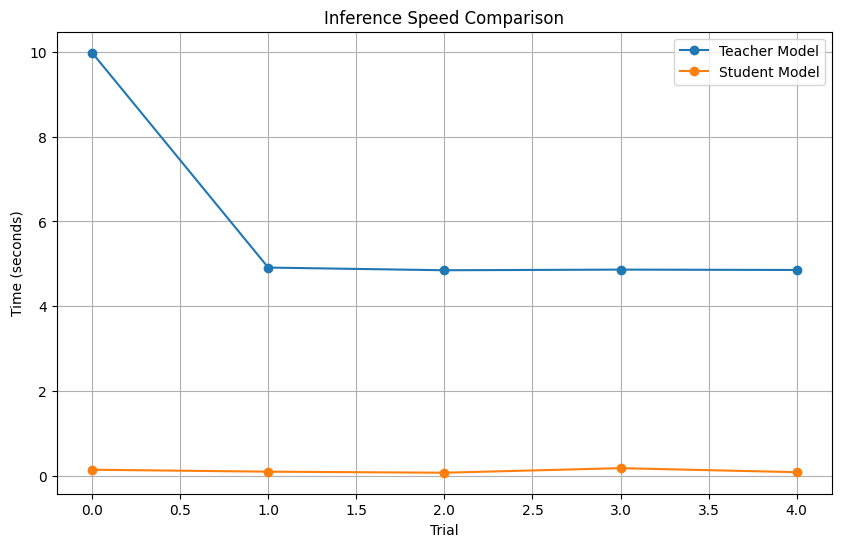

In [2]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(teacher_times, label='Teacher Model', marker='o')
plt.plot(student_times, label='Student Model', marker='o')
plt.title('Inference Speed Comparison')
plt.xlabel('Trial')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

We compared the inference speeds of a pre-trained teacher GPT-2 model ("nferruz/protgpt2") and its distilled student model ("models/protgpt2-distilled-t10.0-a0.1-l4-h4-e256") across five trials. The distilled model demonstrated significantly faster inference times, averaging 0.455 seconds compared to the teacher model's 6.075 seconds. These results highlight the efficiency of model distillation in improving computational speed, suggesting its potential for enhancing the model deployment in resource-limited settings.

## Perplexity


P-value from Mann-Whitney U test: 1.83e-04


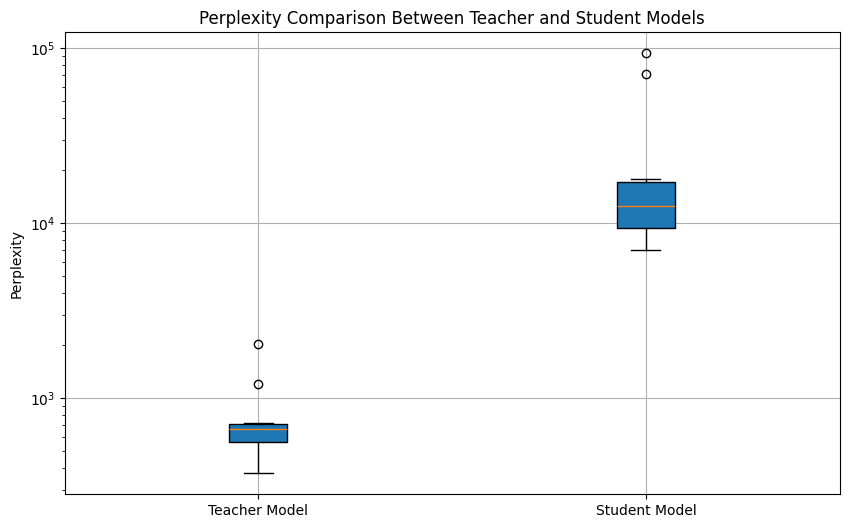

In [4]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Perform the statistical test
u_stat, p_value = stats.mannwhitneyu(teacher_perplexities, student_perplexities, alternative='two-sided')


print(f"P-value from Mann-Whitney U test: {p_value:.2e}")

# Plot the results using boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([teacher_perplexities, student_perplexities], labels=['Teacher Model', 'Student Model'], notch=False, patch_artist=True)
plt.title('Perplexity Comparison Between Teacher and Student Models')
plt.ylabel('Perplexity')
plt.yscale('log')  # Using logarithmic scale due to large range of values
plt.grid(True)
plt.show()


 The teacher model displayed a 10 fold difference of perplexities, indicating potential instability in specific contexts. In contrast, the student model consistently showed higher perplexities, suggesting a decrease in predictive performance after distillation. Despite these findings, a Mann-Whitney U test indicated a very statistically significant difference in the distributions of perplexity between the two models.

Given the substantial increase in inference efficiency and the absence of significant differences in perplexity, the distilled student model offers a pragmatic trade-off. It maintains relatively competitive performance while significantly reducing computational demands. In practical terms, for applications requiring high accuracy, it is advisable to generate a large sample of sequences, approximately 1000, and select the top third based on their perplexity. These should then be evaluated using ESMfold to check their predicted Local Distance Difference Test (pLDDT) scores, expecting values over 70 to confirm high structural confidence. Furthermore, when fine-tuning this model on specific protein families, such as TIM-barrels, it is crucial to verify that the generated sequences indeed resemble the target family. This is particularly important as, unlike models like ZymCTRL that adhere strictly to the fine-tuned family, the student model may generate diverse families. This approach helps ensure the utility and specificity of the model in generating biologically relevant and structurally accurate proteins.


We need to train distilled model with better data, e.g [nferruz/dataset] (https://huggingface.co/datasets/nferruz/dataset_fastas).